In [1]:
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


# <u>Data Preparation

In [2]:
# read images from folder
def load_images_folder(path):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename), 0)
        if img is not None:
            images.append(img)
    return images

In [29]:
# load the images
images_train = load_images_folder('output/Training')

In [30]:
# load the cross validation images
images_cv = load_images_folder('output/PublicTest')
# load the test images
images_test = load_images_folder('output/PrivateTest')

In [31]:
# load the corresponding emotion values
emotions = pd.read_csv('emotions.csv')

In [32]:
images_train = np.array(images_train)
images_cv = np.array(images_cv)
images_test = np.array(images_test)

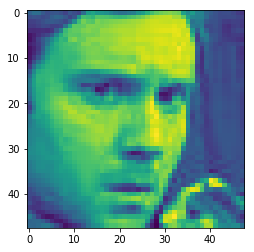

In [7]:
plt.imshow(images_train[0])

In [8]:
print(len(images_train))
print(len(images_cv))
print(len(images_test))
print(len(emotions))

28709
3589
3589
35886


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001615B1A8B38>]], dtype=object)

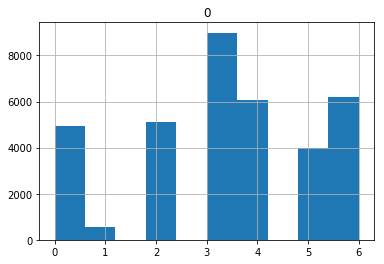

In [8]:
emotions.hist()

In [9]:
# distribution of pictures
emotions["0"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4952
5    4002
1     547
Name: 0, dtype: int64

In [10]:
# prepare output labels 
y_train = emotions[:images_train.shape[0]]
y_cv = emotions[images_train.shape[0]:images_train.shape[0] + images_cv.shape[0]]
y_test = emotions[images_train.shape[0] + images_cv.shape[0]: ]

In [11]:
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(28709, 1)
(3589, 1)
(3588, 1)


In [12]:
# create one hot encoding
y_train_ohe = to_categorical(y_train, num_classes=7)
y_cv_ohe = to_categorical(y_cv, num_classes=7)
y_test_ohe = to_categorical(y_test, num_classes=7)

In [13]:
print(y_train_ohe.shape)
print(y_cv_ohe.shape)
print(y_test_ohe.shape)

(28709, 7)
(3589, 7)
(3588, 7)


# <u>Preprocessing

In [14]:
# preprocess the images
# training images
for i, img in tqdm(enumerate(images_train)):
    images_train[i] = img/255
    
# cv images
for i, img in tqdm(enumerate(images_cv)):
    images_cv[i] = img/255
    
# test images
for i, img in tqdm(enumerate(images_test)):
    images_test[i] = img/255

28709it [00:00, 55675.25it/s]
3589it [00:00, 45949.86it/s]
3589it [00:00, 57424.88it/s]


In [16]:
# save the preprocessed images
np.save('train_img.npy', images_train)
np.save('cv_img.npy', images_cv)
np.save('test_img.npy', images_test)

In [17]:
# reshape the images for keras
images_train = np.expand_dims(images_train, 3)
images_cv = np.expand_dims(images_cv, 3)
images_test = np.expand_dims(images_test, 3)

In [18]:
print(images_train.shape)
print(images_cv.shape)
print(images_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


# <u>Model Architecture

In [23]:
from keras.callbacks import ModelCheckpoint

In [25]:
'''
saves the model weights after each epoch if the validation loss decreased
'''
checkpoint = ModelCheckpoint(filepath='weights_best.hdf5', verbose=1, save_best_only=True)

In [19]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 40, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 102400)            0         
__________

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [28]:
model.fit(images_train, y_train_ohe, batch_size=64, epochs=2, verbose=1,
          validation_data=(images_cv, y_cv_ohe), callbacks=[checkpoint])

model.save_weights('weights.h5')
model.save('model.h5')

Train on 28709 samples, validate on 3589 samples
Epoch 1/2


KeyboardInterrupt: 